In [1]:
from avo.toy_dist import PickleRick, ThreeMixture, SimpleNormal, MixtureTarget, DFunction

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

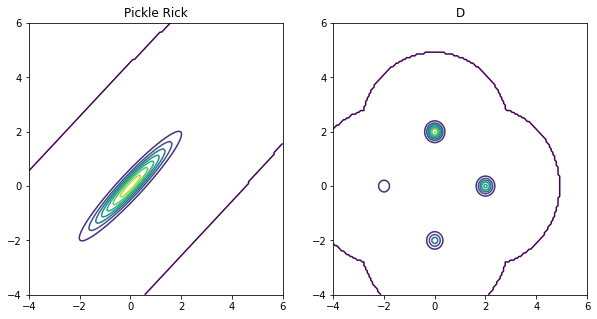

In [24]:
target_names = ['pickle2d', 'mixture2d']
fig, ax = plt.subplots(ncols=2, figsize= (10,5))
targets = {}

for i, t_name in enumerate(target_names):
    if t_name == 'pickle2d':
        L_target = torch.cholesky(torch.Tensor([[1., 0.95], [0.95, 1.]]))
        target = PickleRick(torch.Tensor([0., 0.]).unsqueeze(0).to(device), L_target.to(device))
        
    elif t_name == 'mixture2d':
        # mu = torch.Tensor([0., -2., -2., 2., 2., 2.]).reshape(3, 2)
        # L = torch.cholesky(torch.Tensor([[1., 0], [0, 1.]]))
        # L_ = torch.cholesky(torch.Tensor([[1., -0], [-0, 1.]]))
        # L_vec = torch.stack([L_, L, L_])
        # target = ThreeMixture(mu.to(device), L_vec.to(device))
        # target = MixtureTarget(target, simple_normal, 0.5)
        target = DFunction(device)
    target.plot2d_pdf(ax[i], bounds=((-4, 6), (-4, 6)))
    targets[t_name] = target

# HVI AVO

In [25]:
from avo.models import HVIAVO, HVIELBO
import pytorch_lightning as pl
import torch.nn as nn

In [72]:
models = {}
# models['mixture2d'] = HVIELBO(2, 10, targets['mixture2d'], batch_size=64,  lr=1e-2, hidden_dimension=2).cuda()
models['mixture2d'] = HVIAVO(2, 10, targets['mixture2d'], batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()
# models['mixture2d'] = HVIAVO(2, 10, targets['mixture2d'], batch_size=64,  lr=1e-3, optimizer="sgd").cuda()
models['pickle2d'] = HVIELBO(2, 10, targets['pickle2d'], batch_size=64, lr=1e-3, optimizer="sgd").cpu()

In [73]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=10, gpus=0)
trainer.fit(models['mixture2d'], models['mixture2d'].data_loader(10000));

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   


In [70]:
for transition in models['mixture2d']._transitions:
    print(transition._reverse_module._linear_sigma.bias.data)

tensor([ 0.4477, -0.5777])
tensor([ 0.1712, -0.4610])
tensor([-0.0714, -3.3267])
tensor([0.5585, 0.5315])
tensor([-0.8717,  0.2806])
tensor([-3.5348, -4.2131])
tensor([-2.2653, -2.1728])
tensor([-1.3069, -1.4041])
tensor([-3.7551, -4.2234])
tensor([-4.1012, -3.0602])


In [63]:
torch.nn.Softplus()(torch.tensor([-4.5]))

tensor([0.0110])

In [36]:
trainer.test(models['mixture2d'], models['mixture2d'].data_loader(200));

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'energy': tensor(0.8580), 'entropy': tensor(-0.3103), 'loss': tensor(0.5477)}
--------------------------------------------------------------------------------



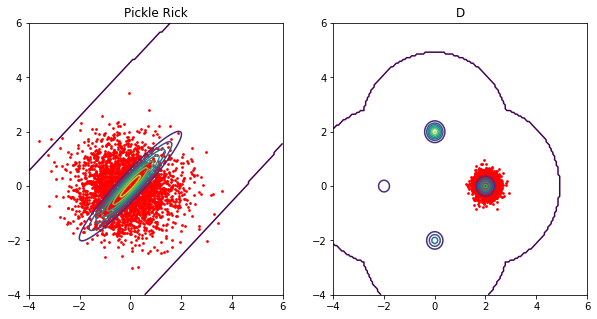

In [71]:
fig, ax = plt.subplots(ncols=2, figsize= (10,5))
models['pickle2d'].to(device)
sample_points = models['pickle2d'].sample(3000).cpu().detach().numpy()
ax[0].scatter(sample_points[:, 0], sample_points[:, 1], s=3, color="red")
models['mixture2d'].to(device)
sample_points = models['mixture2d'].sample(3000).cpu().detach().numpy()
# sample_points = z.cpu().detach().numpy()
ax[1].scatter(sample_points[:, 0], sample_points[:, 1], s=3, color="red")
targets['pickle2d'].plot2d_pdf(ax[0], bounds=((-4, 6), (-4, 6)))
targets['mixture2d'].plot2d_pdf(ax[1], bounds=((-4, 6), (-4, 6)))